## SVM既可以做回归，也可以做分类器
* 当用SVM做回归的时候，我们使用SVR或LinearSVR。SVR全称是 support vector regression
* 当SVM做分类器的时候，我们使用SVC或LinearSVC。SVC全称是 support vector classification
* LinearSVC是个线性分类器，用于处理线性可分的数据，只能使用线性核函数。SVM是通过核函数将样本从原始空间映射到一个更高维的特质空间中，这样使得样本在新的空间中线性可分。
* 针对非线性数据，需要用到SVC。SVC中既可以使用到线性核函数（进行线性划分），也能使用高维的核函数（进行非线性划分）。

## 如何创建一个SVM分类器？
### 使用SVC的构造函数：model = svm.SVC(kernel = 'rbf',C = 1.0,gamma = 'auto')
* kernel代表核函数的选择，默认是rbf
* 1、linear：线性核函数---在数据线性可分的情况下使用，运算速度快，效果好。不足在于不能处理线性不可分的数据。
* 2、poly：多项式核函数---可以将数据从低维空间映射到高维空间，但参数较多，计算量大。
* 3、rbf：高斯核函数（默认）---可将样本映射到高维空间，相较于poly来说所需参数较少，性能不错。
* 4、sigmoid：sigmoid核函数---常用在神经网络的映射中，当使用sigmoid代表实现的是多层神经网络。
* 除了linear外，其余3中函数都可以处理线性不可分的数据。


* 参数C代表目标函数的惩罚系数，惩罚系数指的是分错样本时的惩罚程度，默认等于1.0。当C越大时，分类器的准确性越高，但容错率降低，泛化能力变差。相反，当C越小，泛化能力越强，但准确性会降低。


* 参数gamma代表核函数的系数，默认为样本特征数的倒数。即gamma = 1 / n_features

## 创建SVM分类器后，就可以输入训练集对它进行训练
### 使用model.fit(train_x,train_y)，传入特征值矩阵train_x和分类标识train_y
### 使用prediction=model.predict(test_X) 来对结果进行预测，传入测试集中的样本特征矩阵 test_X，可以得到测试集的预测分类结果 prediction
* 同样，我们也可以创建线性 SVM 分类器，使用 model=svm.LinearSVC()。在 LinearSVC中没有 kernel 这个参数，限制我们只能使用线性核函数。由于 LinearSVC 对线性分类做了优化，对于数据量大的线性可分问题，使用 LinearSVC 的效率要高于 SVC。
* 如果你不知道数据集是否为线性，可以直接使用 SVC 类创建 SVM 分类器。

## 如何使用SVM进行乳腺癌检测
### 流程：
准备阶段
* 1、加载数据源
* 2、数据探索：查看样本特征和特征值
* 3、数据清洗：查看数据情况，是否需要清洗
* 4、特征选择：做特征选择

分类阶段
* 1、选择核函数进行训练，如果不知道数据是否为线性，可使用SVC(Kernel = 'rbf')
* 2、对训练好的模型用测试集进行评估

In [1]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler   # 对数据进行规范化

F:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### 1、加载数据

In [3]:
data = pd.read_csv('E:/Jupyter/算法/data/23.breast_cancer_data-master/data.csv')
display(data.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2、数据探索

In [4]:
# 因为数据集中列比较多，需要把dataframe中的列全部列出来
pd.set_option('display.max_columns',None)

In [5]:
print(data.columns)
print(data.describe())

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000  

### 3、数据清洗
* 32个字段里，id是没有含义的；diagnosis字段取值为B或者M，可以用0或1代替。其余30个字段可以分成三组，分别是mean、se和worst组。分别代表平均值，标准差，最大值

In [6]:
# 将特征字段分为3组
features_mean = list(data.columns[2:12])
features_se = list(data.columns[12:22])
features_worst = list(data.columns[22:32])
features_mean

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean']

In [7]:
# ID列没用，删除
data.drop('id',axis = 1,inplace = True)

In [8]:
# 将良性B替换成0，恶性M替换成1
data['diagnosis'] = data['diagnosis'].map({'B':0,'M':1})
display(data.head())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 4、特征选择

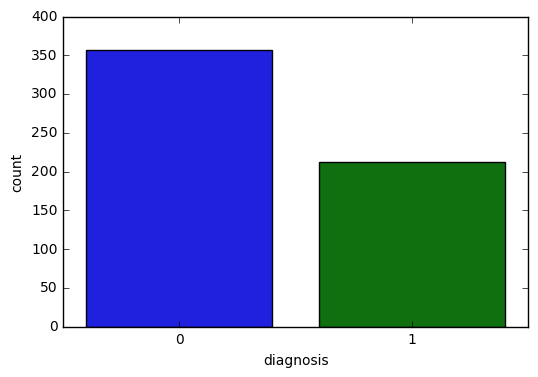

In [9]:
# 将肿瘤诊断结果可视化
sns.countplot(data['diagnosis'],label="Count")
plt.show()

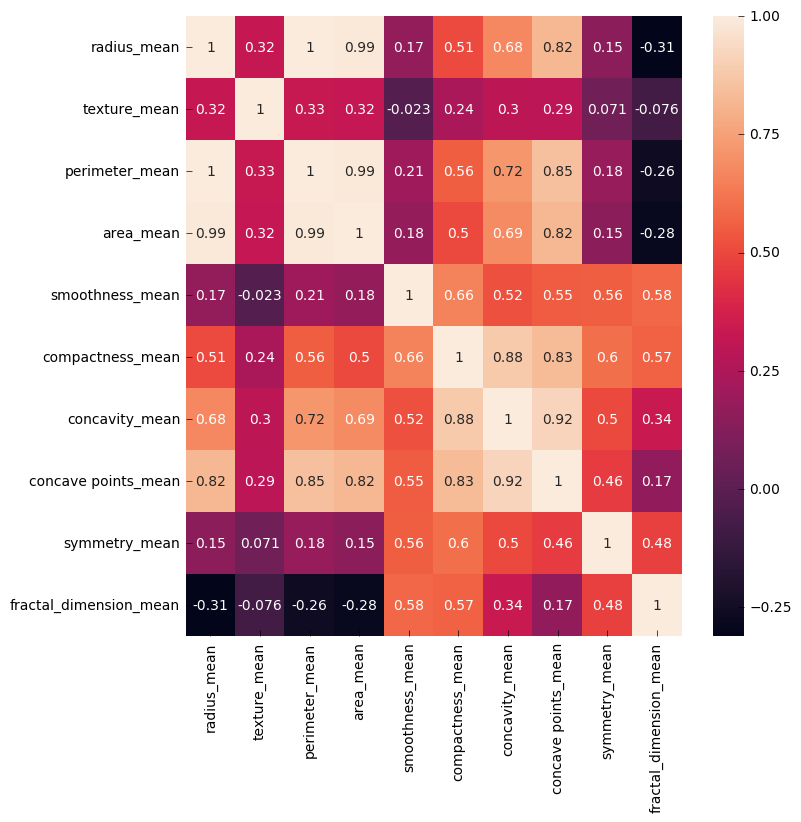

In [14]:
# 用热力图呈现 features_mean 字段之间的相关性
# 颜色越浅，相关性越大
corr = data[features_mean].corr() #相关系数矩阵，即给出了任意两个变量之间的相关系数
plt.figure(figsize = (8,8))
sns.heatmap(corr,annot = True) # annot = True 在格子中显示数值
plt.show()
# 可以看出 radius_mean、perimeter_mean和area_mean三者之间的相关性很大
# compactness_mean、concavity_mean、concave_points_mean三者之间的相关性很大

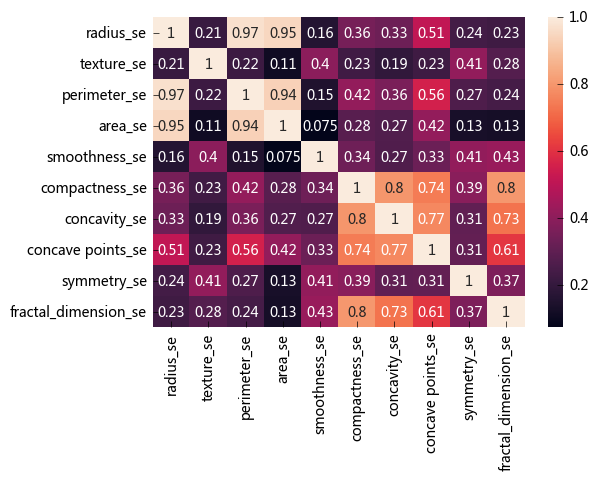

In [45]:
corr = data[features_se].corr()
sns.heatmap(corr,annot = True)
plt.show()

In [10]:
# 特征选择的目的是降维，用少量的特征代表数据的特性，这样可以增强分类器的泛化能力，避免数据过拟合   
# 我们能看到 mean、se、worst这三组特征是对同一组内容的不同度量方式
# 可以保留mean这组特征，在特征选择中忽略se和worst
# radius_mean、perimeter_mean和area_mean三者之间的相关性很大，选择1个属性做代表，比如radius_mean
# compactness_mean、concavity_mean、concave_points_mean三者之间的相关性很大，选择1个属性做代表，比如compactness_mean    

# 特征选择选择上述中的radius_mean 和 compactness_mean，再加上其他相关性不大的属性
features_remain = ['radius_mean','texture_mean', 'smoothness_mean',
                   'compactness_mean','symmetry_mean', 'fractal_dimension_mean'] 

### 5、对特征进行选择之后，就准备训练集和测试集

In [33]:
# 抽取 30% 的数据作为测试集，其余作为训练集
train,test = train_test_split(data,test_size = 0.3)

# 抽取特征选择的数值作为训练和测试数据
train_x = train[features_remain]
train_y = train['diagnosis']
test_x = test[features_remain]
test_y = test['diagnosis']
print(train_x.head())

     radius_mean  texture_mean  smoothness_mean  compactness_mean  \
213        17.42         25.56          0.10060           0.11460   
2          19.69         21.25          0.10960           0.15990   
335        17.06         21.00          0.11190           0.10560   
411        11.04         16.83          0.10770           0.07804   
426        10.48         14.98          0.09816           0.10130   

     symmetry_mean  fractal_dimension_mean  
213         0.1308                 0.05866  
2           0.2069                 0.05999  
335         0.1727                 0.06071  
411         0.1714                 0.06340  
426         0.1925                 0.06915  


In [34]:
# 在训练之前，要对数据进行规范化，让数据在同一个量级上，避免因为维度问题造成数据误差

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
train_x = ss.fit_transform(train_x)
test_x = ss.fit_transform(test_x)
print(train_x)

[[ 0.99485836  1.50873487  0.30925053  0.21578972 -1.86526354 -0.59518478]
 [ 1.65716918  0.48482557  0.95735981  1.08544689  0.89735543 -0.40555704]
 [ 0.88982228  0.42543408  1.12298773  0.04301015 -0.3441895  -0.30290142]
 ...
 [-0.47272906 -0.41079811  0.56849424  0.50567544 -0.15541659  0.43422295]
 [ 1.61632182  2.2713216  -0.2668466   1.97622156  0.25843172 -0.07335205]
 [-0.91329705 -0.8526708   0.31645175  0.0679672   0.14226378  0.78924029]]


### 6、让SVM做训练和预测

In [36]:
# 创建 SVM分类器
model = svm.SVC()
# 用训练集做训练
model.fit(train_x,train_y)
# 用测试集做预测
prediction = model.predict(test_x)
# 预测结果
print(len(prediction))
# 实际结果
print(len(test_y))
print('准确率：',metrics.accuracy_score(test_y,prediction))

171
171
准确率： 0.8830409356725146
